In [12]:
from astropy.io import fits
import clevar
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
from clevar.match_metrics.distances import ClCatalogFuncs as d_cf
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf
import clevar.match_metrics.scaling as scaling

import pandas as pd
from astropy.table import Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
Ncm.cfg_init()

In [11]:
hdul_halos = fits.open("../halos/halos.fits")
hdul_ame = fits.open("richness_mcut_SNR 12_ame.fits")

logMmin = 12.87
logMmax = 15

table_halos = hdul_halos[1].data
table_ame = hdul_ame[1].data
table_halos = table_halos[(table_halos['upid'] == -1)  &  (table_halos['Mvir'] >= 10**logMmin) & (table_halos['Mvir'] <= 10**logMmax)]
table_halos['Mvir'] = table_halos['Mvir']/0.6774

print(table_halos.size)
print(table_ame.size)

#print(table_ame.columns)

print("DEC max")
print(table_ame['DEC'].max())
print(table_halos['DEC'].max())
print('\n')
print("DEC min")
print(table_ame['DEC'].min())
print(table_halos['DEC'].min())
print('\n')
print("RA max")
print(table_ame['RA'].max())
print(table_halos['RA'].max())
print('\n')
print("RA min")
print(table_ame['RA'].min())
print(table_halos['RA'].min())
print('\n')
print("z max")
print(table_ame['z'].max())
print(table_halos['redshift_R'].max())
print('\n')
print("z min")
print(table_ame['z'].min())
print(table_halos['redshift_R'].min())

977436
23751
DEC max
69.987462659708
69.99966430664062


DEC min
20.00571528380776
20.00000762939453


RA max
229.99483480331588
229.99951171875


RA min
110.00560235552096
110.00003814697266


z max
0.6587940911577925
0.6646281966028926


z min
0.0462011092646255
0.00388302828285513


In [6]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_ame = clevar.ClCatalog('Detection catalog', ra=table_ame['RA'], dec=table_ame['DEC']
                             , z=table_ame['z'], mass=table_ame['R_ame']  , mass_err=table_ame['R_ame_err'] ,z_err=table_ame['z_err'] , )
catalog_ame

NameError: name 'table_halos' is not defined

In [7]:
mt = clevar.match.ProximityMatch()

match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'redshift_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                },
    'catalog2': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                }
}

cosmo_astropy = clevar.cosmology.AstroPyCosmology()

#mt.match_from_config(catalog_halos, catalog_ame, match_config, cosmo=cosmo_astropy)
#mt.save_matches(catalog_halos, catalog_ame, out_dir='temp', overwrite=True)

In [8]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_ame = clevar.ClCatalog('Detection catalog', ra=table_ame['RA'], dec=table_ame['DEC']
                             , z=table_ame['z'], mass=table_ame['R_ame']  , mass_err=table_ame['R_ame_err'] ,z_err=table_ame['z_err'] , )
mt = clevar.match.ProximityMatch()
mt.load_matches(catalog_halos, catalog_ame, out_dir='temp')

halos_match, detections_match = clevar.match.get_matched_pairs(catalog_halos, catalog_ame, 'cross')

display(detections_match)

NameError: name 'table_halos' is not defined

In [7]:
halos_match

id,ra,dec,z,mass,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_cross
str6,float64,float64,float64,float64,object,object,object,object,object
199,224.26119995117188,61.05094909667969,0.06559088946901753,98597578978447.0,3464,3464,['3464'],['3464'],3464
202,227.0655975341797,69.02522277832031,0.06731215159473591,25952169323885.445,19744,19744,['19744'],['19744'],19744
239,202.45892333984375,54.67112731933594,0.04515637865836805,142235016238559.2,17390,17390,['17390'],['17390'],17390
244,202.55160522460938,46.27610778808594,0.04696768276389931,54664895187481.55,23132,23132,['23132'],['23132'],23132
277,221.91378784179688,56.833221435546875,0.06468690157334595,99616180986123.4,15185,15185,['15185'],['15185'],15185
279,226.79087829589844,57.10200500488281,0.06249648491402582,60289343076468.85,10943,10943,['10943'],['10943'],10943
295,213.9264373779297,35.454917907714844,0.048956566205078336,76085033953351.05,16490,16490,['16490'],['16490'],16490
347,186.5132598876953,40.69691467285156,0.05278996769064387,83038086802480.08,9114,9114,['9114'],['9114'],9114
386,200.87765502929688,48.99461364746094,0.05746144650250179,89164450841452.61,2331,2331,['2331'],['2331'],2331


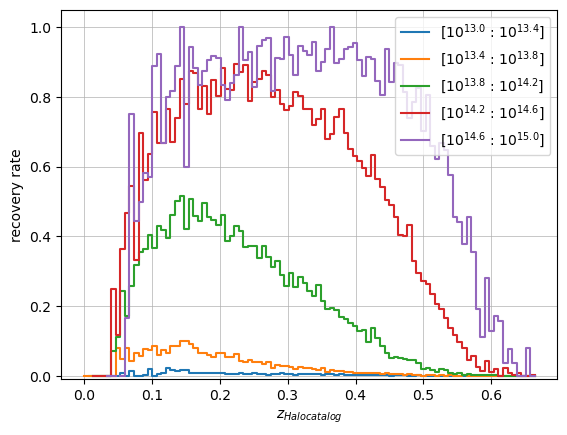

In [8]:
from clevar.match_metrics import recovery
zbins = np.linspace(0.0, 0.664, 100)
mbins = np.logspace(13.0, 15, 6)
info = recovery.plot(cat=catalog_halos, matching_type='cross', redshift_bins=zbins, mass_bins=mbins, shape='steps')
plt.legend()
plt.savefig("recovery_halos_z.jpg")
info['data']['recovery']
plt.show()
m_plot = []

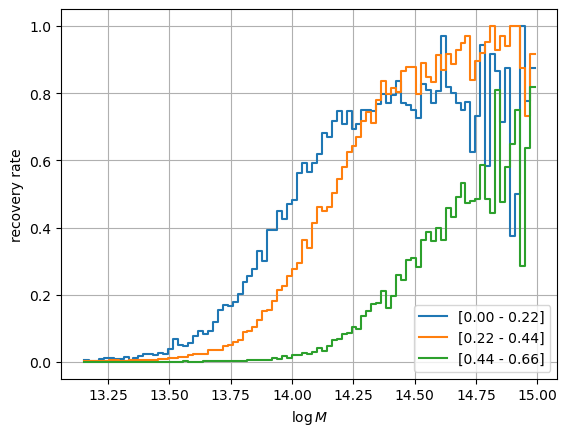

In [14]:
zbins = np.linspace(0.0, 0.664, 2)
mbins = np.logspace(13.0, 15, 100)

#info = recovery.plot(cat=catalog_halos, matching_type='cross', redshift_bins=zbins, mass_bins=mbins, shape='steps')
m_plot = []
for i in range(len(mbins)-1):
    m_plot.append((np.log10(mbins[i])+np.log10(mbins[i+1]))/2)
for j in range(len(zbins)-1):
    
    plt.step(m_plot , info['data']['recovery'][j] , label='[%.2f - %.2f]' % (zbins[j],zbins[j+1]))
    
plt.legend(loc=4)
plt.xlabel(r"$\log M$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_halos_mass.jpg")

<NumCosmoMath.Spline2dBicubic object at 0x7f89d00075c0 (NcmSpline2dBicubic at 0x561cb4229a60)>

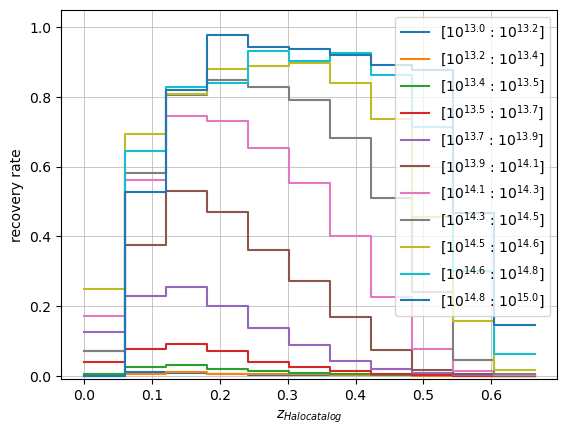

In [9]:
import selection
zbins = np.linspace(0.0, 0.664, 12)
mbins = np.logspace(13.0, 15, 12)
selection_ame = selection.NcClusterSelectionFunction()
info = recovery.plot(cat=catalog_halos, matching_type='cross', redshift_bins=zbins, mass_bins=mbins, shape='steps')
z = Ncm.Vector.new(len(zbins)-1)
lnM = Ncm.Vector.new(len(mbins)-1)
completeness = Ncm.Matrix.new(len(zbins)-1 , len(mbins)-1)
for i in range(z.len()):
    z.set(i , (zbins[i]+zbins[i+1])/2)

for i in range(lnM.len()):
    lnM.set(i , (np.log(mbins[i])+np.log(mbins[i+1]))/2)

    
for i in range(z.len()):
    for j in range(lnM.len()):
        completeness.set(i , j , info['data']['recovery'][j][i])
selection_ame.nc_cluster_selection_function_completeness(z , lnM , completeness)


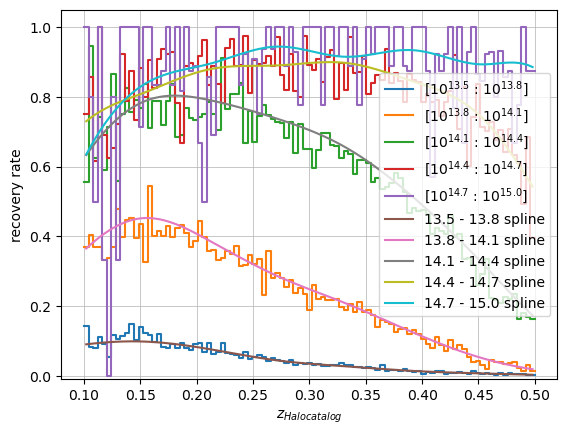

0.7250800723395187


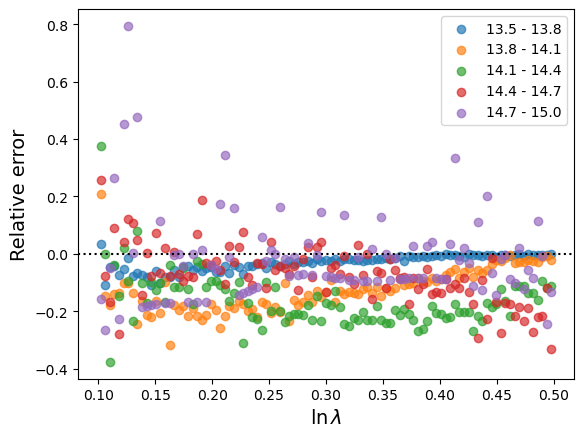

In [10]:
from clevar.match_metrics import recovery
import math
zbins = np.linspace(0.1, 0.5, 100)
mbins = np.logspace(13.5, 15, 6)
info = recovery.plot(catalog_halos, 'cross', zbins, mbins, shape='steps')

for i in range(len(mbins)-1):
    z_plot = []
    completeness = []
    completeness_i = []
    completeness_analytical = []
    for j in range(len(zbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_completeness_eval((zbins[j]+zbins[j+1])/2, 
        (np.log(mbins[i])+np.log(mbins[i+1]))/2))
        z_plot.append((zbins[j]+zbins[j+1])/2)
        
    plt.plot(z_plot , completeness, label="%.1f - %.1f spline" % (np.log10(mbins[i]),np.log10(mbins[i+1])))
    
plt.legend()
plt.show()



for i in range(len(mbins)-1):
    completeness = []
    diff = []
    for j in range(len(zbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_completeness_eval((zbins[j]+zbins[j+1])/2 , np.log(mbins[i]) ))
        diff.append((completeness[j]-info['data']['recovery'][j-1][i]))
    plt.scatter(z_plot, diff, alpha=0.6774, label="%.1f - %.1f" % (np.log10(mbins[i]),np.log10(mbins[i+1])))
plt.legend()
plt.xlabel(r'$\ln\lambda$', size=14)
plt.ylabel('Relative error', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted') 
print(selection_ame.nc_cluster_selection_function_completeness_integ(zbins[0], zbins[-1], np.log(mbins[0]) , np.log(mbins[-1])))

ValueError: x and y must have same first dimension, but have shapes (99,) and (5,)

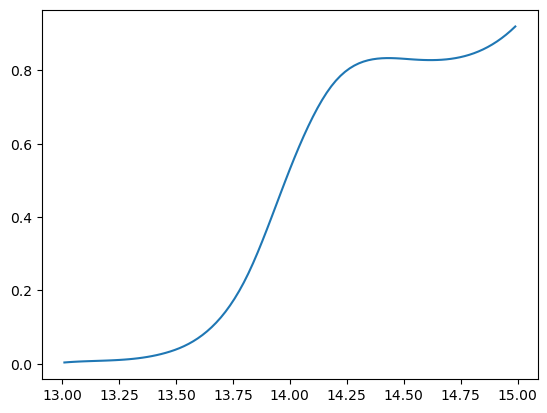

In [11]:
from clevar.match_metrics import recovery

zbins = np.linspace(0.1, 0.5, 4)
mbins = np.logspace(13.0, 15, 100)
rbins = np.logspace(0 , 3, 2)
#info = recovery.plot(catalog_halos, 'cross', zbins, mbins, shape='steps')
plt.show()
for i in range(len(zbins)-1):
    lnM_plot = []
    completeness = []
    for j in range(len(mbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_completeness_eval((zbins[i]+zbins[i+1])/2, 
        (np.log(mbins[j])+np.log(mbins[j+1]))/2))
        lnM_plot.append((np.log10(mbins[j])+np.log10(mbins[j+1]))/2)
    plt.plot(lnM_plot , completeness, label="[%.2f - %.2f] interpol" % (zbins[i],zbins[i+1]))   
    
    plt.step(lnM_plot , info['data']['recovery'][i] , label='[%.2f - %.2f] data' % (zbins[i],zbins[i+1]))
    #print( info['data']['recovery'])
    
    
plt.legend()

{'data': {'recovery': array([[       nan,        nan,        nan,        nan],
       [       nan, 0.47727273, 0.27678571, 0.        ],
       [       nan, 0.62871287, 0.53761062,        nan],
       [       nan, 0.78187919, 0.73913043, 1.        ],
       [       nan, 0.88178914, 0.87113402,        nan],
       [       nan, 0.90670554, 0.9       , 0.66666667],
       [       nan, 0.96899225, 0.93976576, 0.75      ],
       [       nan, 0.97073171, 0.96223709, 0.83333333],
       [       nan, 0.984     , 0.96578118, 0.66666667],
       [       nan, 0.98058252, 0.97145488, 0.8       ],
       [       nan, 1.        , 0.98659004, 0.66666667],
       [       nan, 0.97647059, 0.98980632, 0.71428571],
       [       nan, 1.        , 0.98861594, 0.90909091],
       [       nan, 1.        , 0.98626374, 0.88888889],
       [       nan, 0.97916667, 0.99030068, 1.        ],
       [       nan, 0.97222222, 0.98352554,        nan],
       [       nan, 1.        , 0.98705502,        nan],
       [ 

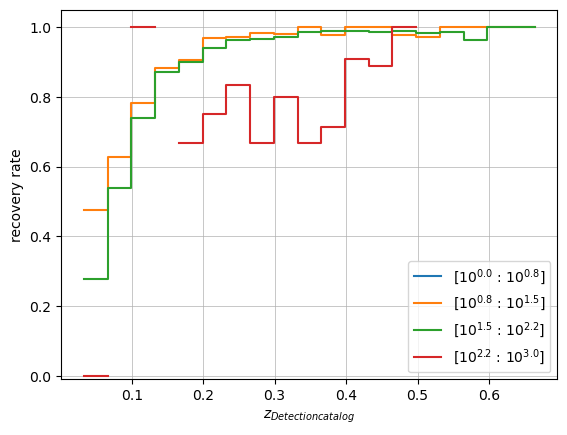

In [11]:
zbins = np.linspace(0.0, 0.664, 21)
rbins = np.logspace(0, 3, 5)

info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')

plt.legend()
plt.savefig("recovery_detections_z.jpg")
print(info)


In [12]:
zbins = np.linspace(0.0, 0.664, 2)
rbins = np.logspace(1.1 , 2.3 100)

#info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')
r_plot = []
for i in range(len(rbins)-1):
    r_plot.append((np.log(rbins[i])+np.log(rbins[i+1]))/2)
for j in range(len(zbins)-1):
    
    plt.step(r_plot , info['data']['recovery'][j] , label='[%.2f - %.2f]' % (zbins[j],zbins[j+1]))
    
plt.legend(loc=3)
plt.xlabel(r"$\ln \lambda$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_detections_rich.jpg")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2306024151.py, line 2)

In [ ]:
zbins = np.linspace(0.1, 0.5, 7)
rbins = np.logspace(1.3 , 2.3, 7)

info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')
z = Ncm.Vector.new(len(zbins)-1)
lnR = Ncm.Vector.new(len(rbins)-1)
purity = Ncm.Matrix.new(len(zbins)-1 , len(rbins)-1)
for i in range(z.len()):
    z.set(i , (zbins[i]+zbins[i+1])/2)

for i in range(lnR.len()):
    lnR.set(i , (np.log(rbins[i])+np.log(rbins[i+1]))/2)

    
for i in range(z.len()):
    for j in range(lnR.len()):
        purity.set(i , j , info['data']['recovery'][j][i])
selection_ame.nc_cluster_selection_function_purity(z , lnR , purity)

info['data']

In [ ]:
from clevar.match_metrics import recovery
import math
zbins = np.linspace(0.1, 0.5, 100)
rbins = np.logspace(1.3 , 2.3, 7)

info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')

for i in range(len(rbins)-1):
    z_plot = []
    purity = []

    for j in range(len(zbins)-1):
        purity.append(selection_ame.nc_cluster_selection_function_purity_eval((zbins[j]+zbins[j+1])/2, 
        (np.log(rbins[i])+np.log(rbins[i+1]))/2))
        z_plot.append((zbins[j]+zbins[j+1])/2)
        
    plt.plot(z_plot , purity, label="%.1f - %.1f spline" % (np.log10(rbins[i]),np.log10(rbins[i+1])))
    
plt.legend()
plt.show()



for i in range(len(rbins)-1):
    completeness = []
    diff = []
    for j in range(len(zbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_purity_eval((zbins[j]+zbins[j+1])/2 , np.log(rbins[i]) ))
        diff.append((completeness[j]-info['data']['recovery'][j-1][i]))
    plt.scatter(z_plot, diff, alpha=0.6774, label="%.1f - %.1f" % (np.log10(rbins[i]),np.log10(rbins[i+1])))
plt.legend()
plt.xlabel(r'$\ln\lambda$', size=14)
plt.ylabel('Relative error', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted') 
print(selection_ame.nc_cluster_selection_function_completeness_integ(zbins[0], zbins[-1], np.log(rbins[0]) , np.log(rbins[-1])))

In [ ]:
from clevar.match_metrics import recovery

zbins = np.linspace(0.1, 0.5, 4)
rbins = np.logspace(1.3 , 2.3, 100)
#info = recovery.plot(catalog_ame, 'cross', zbins, rbins, shape='steps')
plt.show()
for i in range(len(zbins)-1):
    lnR_plot = []
    completeness = []
    for j in range(len(rbins)-1):
        completeness.append(selection_ame.nc_cluster_selection_function_purity_eval((zbins[i]+zbins[i+1])/2, 
        (np.log(rbins[j])+np.log(rbins[j+1]))/2))
        lnR_plot.append((np.log10(rbins[j])+np.log10(rbins[j+1]))/2)
    plt.plot(lnR_plot , completeness, label="[%.2f - %.2f] interpol" % (zbins[i],zbins[i+1]))   
    
    plt.step(lnR_plot , info['data']['recovery'][i] , label='[%.2f - %.2f] data' % (zbins[i],zbins[i+1]))
    #print( info['data']['recovery'])
    
    
plt.legend()

In [14]:
hdul_ame_large = fits.open("mock_jpas_clusters.fits")
hdul_halos = fits.open("../halos/halos.fits")

logMmin = 12.87
logMmax = 15

table_halos = hdul_halos[1].data
table_ame_large = hdul_ame_large[1].data
table_halos = table_halos[(table_halos['upid'] == -1)  &  (table_halos['Mvir'] >= 10**logMmin) & (table_halos['Mvir'] <= 10**logMmax)]
table_halos['Mvir'] = table_halos['Mvir']/0.6774


print(table_halos.size)
print(table_ame_large.size)

print(table_ame_large.columns)


print("DEC max")
print(table_ame_large['DEC'].max())
print(table_halos['DEC'].max())
print('\n')
print("DEC min")
print(table_ame_large['DEC'].min())
print(table_halos['DEC'].min())
print('\n')
print("RA max")
print(table_ame_large['RA'].max())
print(table_halos['RA'].max())
print('\n')
print("RA min")
print(table_ame_large['RA'].min())
print(table_halos['RA'].min())
print('\n')
print("z max")
print(table_ame_large['z'].max())
print(table_halos['redshift_R'].max())
print('\n')
print("z min")
print(table_ame_large['z'].min())
print(table_halos['redshift_R'].min())


print(table_ame_large['ID'])

977436
935286
ColDefs(
    name = 'ID'; format = 'J'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'z'; format = 'D'
    name = 'z_err'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'SNR_ORIG'; format = 'D'
    name = 'richness'; format = 'D'
    name = 'radius'; format = 'D'
    name = 'rank'; format = 'J'
)
DEC max
69.99996894224543
69.99966430664062


DEC min
20.000013572141572
20.00000762939453


RA max
229.99997980216173
229.99951171875


RA min
110.00011835510142
110.00003814697266


z max
0.6698770106012737
0.6646281966028926


z min
0.038377973503145486
0.00388302828285513
[     1      2      3 ... 888071 928717 887378]


In [8]:
catalog_halos = clevar.ClCatalog('Halo catalog',ra=table_halos['RA'] ,dec=table_halos['DEC'] 
                                ,z=table_halos['redshift_R'], mass=table_halos['Mvir'])

catalog_ame_large = clevar.ClCatalog('Detection catalog', ra=table_ame_large['RA'], dec=table_ame_large['DEC']
                             , z=table_ame_large['z'], SN=table_ame_large['SNR']  ,z_err=table_ame_large['z_err'] , )

In [9]:
mt = clevar.match.ProximityMatch()

match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'angular_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                },
    'catalog2': {'delta_z':0.01,
                'match_radius': '1 Mpc'
                }
}

cosmo_astropy = clevar.cosmology.AstroPyCosmology()

#mt.match_from_config(catalog_halos, catalog_ame_large, match_config, cosmo=cosmo_astropy)
#mt.save_matches(catalog_halos, catalog_ame_large, out_dir='temp_large', overwrite=True)
mt.load_matches(catalog_halos, catalog_ame_large, out_dir='temp_large')

halos_match, detections_match_large = clevar.match.get_matched_pairs(catalog_halos, catalog_ame_large, 'cross')

Halo catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    977,436
 * multiple (self):  678,936
 * multiple (other): 678,936
 * unique (self):    548,575
 * unique (other):   548,563
 * cross:            548,358

Detection catalog
    * ClEvar used in matching: 0.15.3
 * Total objects:    935,286
 * multiple (self):  551,248
 * multiple (other): 551,248
 * unique (self):    548,563
 * unique (other):   548,575
 * cross:            548,358


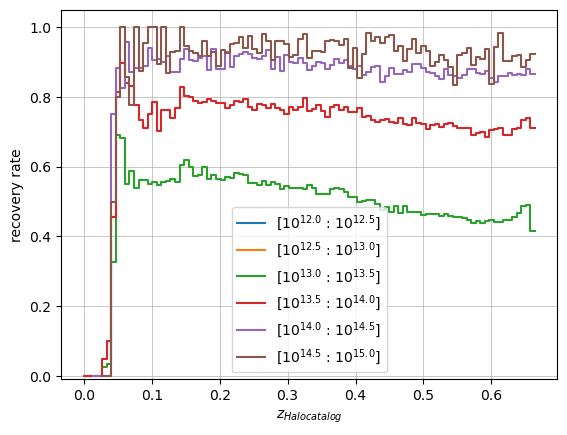

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


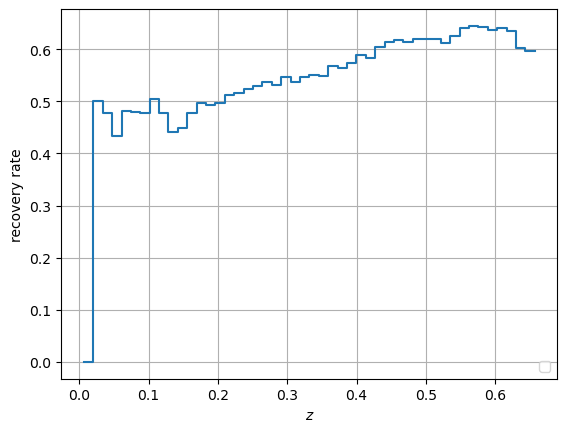

In [10]:
from clevar.match_metrics import recovery

zbins = np.linspace(0.0, 0.664, 100)
mbins = np.logspace(12.0, 15, 7)
info = recovery.plot(cat=catalog_halos, matching_type='cross', redshift_bins=zbins, mass_bins=mbins, shape='steps')
plt.legend()
plt.savefig("recovery_halos_z.jpg")
info['data']['recovery']
plt.show()


zbins = np.linspace(0.0, 0.664, 50)
rbins = np.logspace(0, 3, 2)

recovery_z = []
z_plot   = []

for i in range(len(zbins)-1):
    n_recovered  = 0
    n_detections = 0
    for j in range(len(detections_match_large["z"])):
        if  detections_match_large["z"][j] >=zbins[i] and detections_match_large["z"][j] <=zbins[i+1]:
            n_recovered +=1
            
    for j in range(len(table_ame_large["z"])):
        if  table_ame_large["z"][j] >=zbins[i] and table_ame_large["z"][j] <=zbins[i+1]:
            n_detections +=1
    
    if n_recovered == 0:
        recovery_z.append(0)
    else:
        recovery_z.append(n_recovered/n_detections)
    z_plot.append((zbins[i] + zbins[i+1])/2)            


plt.step(z_plot , recovery_z)

plt.legend(loc=4)
plt.xlabel(r"$z$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_detections_z.jpg")

[38.         38.         38.         ...  3.49986783  3.38048662
  3.50125335]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


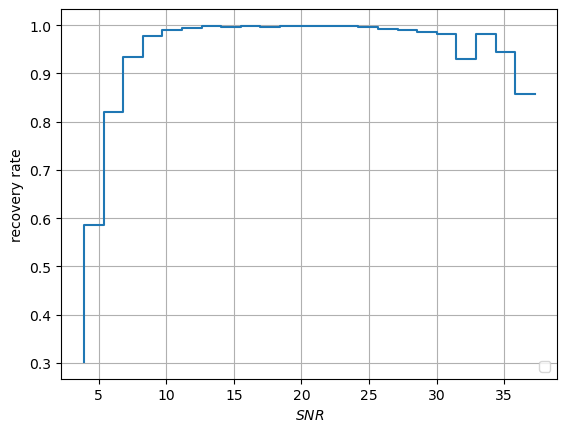

In [34]:
import math
#detections_match_large['SN'].sort()
#table_ame_large['SNR'].sort()

for i in range(len(table_ame_large['SNR'])):
    if math.isinf(table_ame_large['SNR'][i]):
        table_ame_large['SNR'][i] = 38.0
    if math.isnan(table_ame_large['SNR'][i]):
        table_ame_large['SNR'][i] = 0
print( table_ame_large['SNR'])

for i in range(len(detections_match_large['SN'])):
    if math.isinf(detections_match_large['SN'][i]):
        detections_match_large['SN'][i] = 38.0
    if math.isnan(detections_match_large['SN'][i]):
        detections_match_large['SN'][i] = 0
        
snr = np.linspace(detections_match_large['SN'].min(), 38, 25)     

recovery_snr = []
snr_plot   = []
for i in range(len(snr)-1):
    n_recovered  = 0
    n_detections = 0
    for j in range(len(detections_match_large["SN"])):
        if  detections_match_large["SN"][j] >=snr[i] and detections_match_large["SN"][j] <=snr[i+1]:
            n_recovered +=1
            
    for j in range(len(table_ame_large["SNR"])):
        if  table_ame_large["SNR"][j] >=snr[i] and table_ame_large["SNR"][j] <=snr[i+1]:
            n_detections +=1
    
    if n_recovered == 0:
        recovery_snr.append(0)
    else:
        recovery_snr.append(n_recovered/n_detections)
    snr_plot.append((snr[i] + snr[i+1])/2)            

plt.step(snr_plot , recovery_snr)

plt.legend(loc=4)
plt.xlabel(r"$SNR$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_detections_snr.jpg")


[0.20441669 0.31948445 0.27900035 ... 0.10361637 0.11697517 0.10814373]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


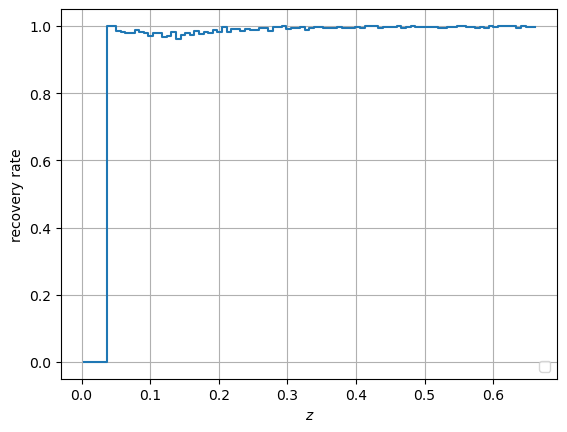

In [26]:
table_ame_large = hdul_ame_large[1].data
halos_match, detections_match_large = clevar.match.get_matched_pairs(catalog_halos, catalog_ame_large, 'cross')

#detections_match_large['z'].sort()
#table_ame_large['z'].sort()

detections_match_large_10 = detections_match_large[(detections_match_large["SN"] >= 10)]
table_ame_large_10 = table_ame_large[(table_ame_large["SNR"] >= 10)]
print(table_ame_large_10['z'])

zbins = np.linspace(0.0, 0.664, 100)
rbins = np.logspace(0, 3, 2)

recovery_z = []
z_plot   = []

for i in range(len(zbins)-1):
    n_recovered  = 0
    n_detections = 0
    for j in range(len(detections_match_large_10["z"])):
        if  detections_match_large_10["z"][j] >=zbins[i] and detections_match_large_10["z"][j] <=zbins[i+1]:
            n_recovered +=1
            
    for k in range(len(table_ame_large_10["z"])):
        if  table_ame_large_10["z"][k] >=zbins[i] and table_ame_large_10["z"][k] <=zbins[i+1]:
            n_detections +=1

    if n_recovered == 0:
        recovery_z.append(0)
    else:
        recovery_z.append(n_recovered/n_detections)
    z_plot.append((zbins[i] + zbins[i+1])/2)            

plt.step(z_plot , recovery_z)

plt.legend(loc=4)
plt.xlabel(r"$z$")
plt.ylabel("recovery rate")
plt.grid()
plt.savefig("recovery_detections_z_SNR10.jpg")

In [1]:
from numcosmo_py import Ncm, Nc
from numcosmo_py.app import NcSkyMatching
Ncm.cfg_init()

cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegac",0.3089 - 0.0486) #0.2603
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0) #-1.0

halo_names = {"RA": 'RA' , "DEC": "DEC" , "z": 'redshift_R'}
halo_property = {"mass": "Mvir"}
cluster_names = {"RA": 'RA' , "DEC": "DEC" , "z": 'z'}
cluster_property = {"SNR":'SNR' , 'z_err':'z_err'}


test = NcSkyMatching.NcSkyMatching(cat1="../halos/halos.fits", cat1_coordinates=halo_names, cat2="mock_jpas_clusters.fits", 
                                   cat2_coordinates=cluster_names, cat1_properties=halo_property, cat2_properties=cluster_property)

matches = test.process_halos(cosmo=cosmo , matching_distance=1, n_nearest_neighbours=10, match_file="test.fits")


#print(str(recovery_z))
#z_plot

ColDefs(
    name = 'Mvir'; format = 'D'
    name = 'upid'; format = 'K'; null = -9223372036854775808
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'redshift_R'; format = 'D'
)
ColDefs(
    name = 'ID'; format = 'J'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'z'; format = 'D'
    name = 'z_err'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'SNR_ORIG'; format = 'D'
    name = 'richness'; format = 'D'
    name = 'radius'; format = 'D'
    name = 'rank'; format = 'J'
)


100%|██████████| 935286/935286 [02:21<00:00, 6631.91it/s]


In [ ]:
from numcosmo_py import Ncm, Nc
from numcosmo_py.app import NcSkyMatching
Ncm.cfg_init()

cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegac",0.3089 - 0.0486) #0.2603
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0) #-1.0

halo_names = {"RA": 'RA' , "DEC": "DEC" , "z": 'redshift_R'}
halo_property = {"mass": "Mvir"}
cluster_names = {"RA": 'RA' , "DEC": "DEC" , "z": 'z'}
cluster_property = {"SNR":'SNR' , 'z_err':'z_err'}


test = NcSkyMatching.NcSkyMatching(cat2="../halos/halos.fits", cat2_coordinates=halo_names, cat1="mock_jpas_clusters.fits", 
                                   cat1_coordinates=cluster_names, cat2_properties=halo_property, cat1_properties=cluster_property)

matches = test.process_halos(cosmo=cosmo , matching_distance=1, n_nearest_neighbours=10, match_file="test2.fits")


#print(str(recovery_z))
#z_plot


ColDefs(
    name = 'ID'; format = 'J'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'z'; format = 'D'
    name = 'z_err'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'SNR_ORIG'; format = 'D'
    name = 'richness'; format = 'D'
    name = 'radius'; format = 'D'
    name = 'rank'; format = 'J'
)
ColDefs(
    name = 'Mvir'; format = 'D'
    name = 'upid'; format = 'K'; null = -9223372036854775808
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'redshift_R'; format = 'D'
)


100%|██████████| 61547206/61547206 [1:19:09<00:00, 12957.67it/s] 


In [10]:
import numpy as np
import pandas as pd
matched_df = pd.DataFrame(matches)

for i in range(len(matched_df["mass"])):
    for j in range(len(matched_df["mass"][i])):
        matched_df["mass"][i][j] = np.log10(matched_df["mass"][i][j]) 

matched_df

,ID,RA,DEC,z,ID_matched,RA_matched,DEC_matched,z_matched,distances Mpc,mass,SNR,z_err
0,0,170.865656,20.458881,0.204417,[1933418.0],[170.8599853515625],[20.45135498046875],[0.2042001130904699],[0.8749856096937029],[10.473632926873842],inf,0.004417
1,1,172.376162,25.770754,0.319484,[],[],[],[],[],[],inf,0.009484
2,2,127.425242,43.722750,0.279000,"[33782394.0, 33782991.0, 4348261.0, 4347787.0,...","[127.43619537353516, 127.41588592529297, 127.4...","[43.71806335449219, 43.71728515625, 43.7182006...","[0.2790941277460835, 0.2791223017047922, 0.278...","[0.403727096411406, 0.49833799883440444, 0.707...","[10.501333171799814, 9.932568228673325, 10.034...",inf,0.009000
3,3,177.221895,27.535949,0.429678,[],[],[],[],[],[],inf,0.009678
4,4,172.225257,32.400104,0.300575,"[4958085.0, 35613115.0, 4957911.0, 35613296.0,...","[172.237548828125, 172.20814514160156, 172.226...","[32.40239715576172, 32.40069580078125, 32.4019...","[0.3005457241829198, 0.3005986812251518, 0.300...","[0.25411049149656106, 0.32414029254393545, 0.3...","[10.526375858696536, 10.867428187439119, 10.64...",inf,0.010575
...,...,...,...,...,...,...,...,...,...,...,...,...
935281,935281,128.747433,56.961602,0.452755,[],[],[],[],[],[],3.385798,0.002755
935282,935282,206.326414,27.874282,0.505460,[],[],[],[],[],[],3.371560,0.005460
935283,935283,138.775780,28.071485,0.189524,[],[],[],[],[],[],3.499868,0.000476
935284,935284,171.330269,45.642348,0.422865,[],[],[],[],[],[],3.380487,0.002865
